## 利用GPT大型模型工具完成数据洞察

10211900416 郭夏辉


**本周以及下周的实验内容如下：**
请同学们参考《GPT数据科学系列课程实验手册》内容，并结合之前的作业经验，对GitHub上具有协作行为日志数据的500名用户的个人信息（包括姓名、公司、邮箱及其地理位置等）进行数据洞察分析。数据获取链接为：https://github.com/X-lab2017/dase-2024-autumn/tree/main/HomeWork/data/user_data

### 实验目标
- 培养数据处理与分析能力：通过实际操作，提升对大规模数据集的处理和分析能力。
- 掌握GPT工具的应用：学习如何利用GPT大型模型工具辅助完成数据洞察任务。
- 理解数据隐私与伦理：在处理包含个人信息的数据时，遵循数据隐私保护的原则和规范。
### 实验内容
1. 人口统计分析
- 国家和地区分布：统计用户所在国家和地区的分布，识别主要的开发者集中地。
- 城市级别分布：分析主要城市的开发者密度，发现技术热点区域。
- 时区分布:了解用户的时区分布，分析不同地区用户的协作时间模式。
2. 协作行为分析
- 提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。
3. 其他维度有趣的洞察（至少2个）
### 提交内容
- 数据分析代码。
- 最终的数据洞察报告（PDF格式）。

### 实验过程
#### 1. 人口统计分析
首先考察一下各项指标的缺失值。

In [1]:
import pandas as pd

# 读取源文件
df = pd.read_csv('data/users_combined_info_500.csv')

# 查看缺失值
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_data_report = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': missing_values,
    'Missing Percentage (%)': missing_percent
})

# 输出结果
print(missing_data_report)

                          Column  Missing Values  Missing Percentage (%)
user_id                  user_id               0                0.000000
name                        name               0                0.000000
location                location               0                0.000000
total_influence  total_influence               0                0.000000
country                  country           88151                6.808205
event_type            event_type               0                0.000000
event_action        event_action               0                0.000000
event_time            event_time               0                0.000000


可以看到，`country`一栏的缺失值较多，因此我们需要对`country`列中存在缺失值的数据进行进一步洞察，检查它们的`location`列是否包含可用于推断`country`的信息。我们看一下所有`country`列缺失的条目的`location`值。

In [2]:
# 筛选出 'country' 列缺失值对应的条目
missing_country_data = df[df['country'].isnull()]

missing_locations = set(missing_country_data['location'])

print("缺失的 'country' 对应的独有 'location' 如下：")
for location in missing_locations:
    print(location)

缺失的 'country' 对应的独有 'location' 如下：
I’m on earth right now.
Earth
The Blue Planet
Earth, Milky Way
</>
Europe (CET)
☁️
European Union
Europe
localhost
Barcelona
Acheron, Hades
ed25519/0x156B038E61A4C823
Everything everywhere all at once.
$HOME
5 centimeters from the screen
Internet
The Nearest Event Horizon
GPS based...
Planet Earth
The Internet
::1
0.0.0.0
Solar system
Ether
Skies
Lyoko
UTC+2
UTC+1
Ireland
CYBERSPACE
$PYTHONPATH
きさらぎ駅
.


让GPT分析所有上述数据，下面四个值可以推断出`country`值：
- `Barcelona`: 明确提到的城市（在西班牙），可以用来补全 country = Spain。
- `Ireland`: 直接提供了国家名，可以用来补全 country = Ireland。
- `European Union`: 泛指欧洲地区，可以补全为一个通用值 country = Europe。
- `Europe (CET)`: 提到欧洲时区，可以补全为 country = Europe。
而其他的都是用户随意编写的location，我们把他们的`country`值补全为`Unknown`。

In [3]:
# country值补全
# 映射规则
location_to_country = {
    'Barcelona': 'Spain',
    'Ireland': 'Ireland',
    'European Union': 'Europe',
    'Europe (CET)': 'Europe'
}

df['country'] = df.apply(
    lambda row: location_to_country.get(row['location'], 'Unknown') if pd.isnull(row['country']) else row['country'],
    axis=1
)

remaining_missing_countries = df['country'].isnull().sum()
print(f"补全后，缺失的country值数：{remaining_missing_countries}")

补全后，缺失的country值数：0


接下来我们要统计各国的开发者总数了，绘制饼图展示各国家开发者的分布。我只展示开发者数量较多的国家，将其他国家合并为 "Others"。

数据中的每条记录代表的是开发者活动，而不是一个开发者，因此统计时要对`user_id`去重，确保每个开发者只被统计一次。

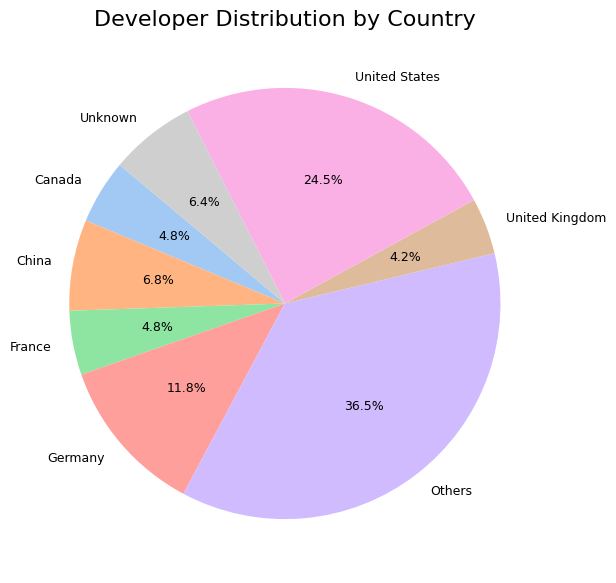

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 统计独立开发者总数（基于之前代码的结果）
unique_developers = df[['user_id', 'country']].drop_duplicates()
country_counts = unique_developers['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Developer Count']

# 将少于某个数量的国家归为 "Others"
threshold = 20 
country_counts['Country'] = country_counts['Country'].apply(
    lambda x: x if country_counts[country_counts['Country'] == x]['Developer Count'].values[0] >= threshold else 'Others'
)
country_counts = country_counts.groupby('Country').sum().reset_index()

sizes = country_counts['Developer Count']
labels = country_counts['Country']

colors = sns.color_palette('pastel', len(sizes))

plt.figure(figsize=(10, 7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 9}
)
plt.title('Developer Distribution by Country', fontsize=16)
plt.show()

三大开发者集中地：
美国（United States）：占比 24.5%，是本例数据集中开发者分布的最主要集中地，反映了美国作为技术和开源社区中心的重要地位。
德国（Germany）：占比 11.8%，是欧洲范围内开发者最为集中的国家，也是世界第二的开发者集中地。
中国（China）：占比 6.8%，是亚洲范围内开发者最为集中的国家，也是世界第三的开发者集中地。

分析可以发现，开源开发活动具有明显的区域性，美国和欧洲是热点区域。中国、澳大利亚和加拿大等国家也有着可观的开发者参与度，这些国家在开源社区中的潜力很大。

In [5]:
import plotly.express as px
unique_developers = df[['user_id', 'country']].drop_duplicates()

country_counts = unique_developers['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Developer Count']

# 使用 Plotly 绘制地图
fig = px.choropleth(
    country_counts,
    locations='Country',
    locationmode='country names',  # 按国家名称匹配
    color='Developer Count',
    color_continuous_scale='OrRd',  # 热力图颜色
    title='Developer Distribution by Country'
)

# 显示地图
fig.update_layout(
    title_font_size=20,
    geo=dict(showframe=False, showcoastlines=True)
)
fig.show()


In [6]:
# 查看城市信息
# 所有不重复的 location 信息
unique_locations = set(df['location'].dropna())

print("所有独特的 location 信息如下：")
for location in sorted(unique_locations):  # 排序后打印，方便查看
    print(location)

所有独特的 location 信息如下：
$HOME
$PYTHONPATH
.
0.0.0.0
5 centimeters from the screen
::1
</>
Aaramoun, Lebanon
Acheron, Hades
Addis Ababa
America/Vancouver
Amherst, MA
Amsterdam
Amsterdam, NY, USA
Amsterdam, Netherlands
Amsterdam, The Netherlands
Appleton, WI
Arkansas, US
Arnhem
Astrakhan, Russia
Athens, Greece
Auckland, New Zealand
Austin, TX
Australia
Austria, Europe
Baltimore, MD, USA
Bandung, Indonesia
Barcelona
Bavaria, Germany
Beijing
Beijing China
Beijing, China
Belgium
Bend, OR
Berkeley, CA
Berlin
Berlin, Germany
Bogota
Boise ID
Bordeaux
Boston
Boston, USA
Bothell, WA
Boulder, CO
Brazil
Brisbane
Brisbane, Australia
Brooklyn, NY
Budapest, HU
CHN, Shandong
CYBERSPACE
California
Cambridge, MA
Canada
Canberra
Canberra, ACT, Australia
Canberra, Australia
Cape Town, South Africa
Cardiff, UK
Chengdu, Sichuan, China
Chicago, IL
China
Chongqing, China
Cologne
Colorado
Copenhagen
Copenhagen, Denmark
Cracow
Cuenca, Ecuador
Cupertino
Cupertino, CA
Czechia
Delaware (but Philly at heart)
Denmark
D

让GPT分析上述的所有`location`值。由于`location`的值格式千奇百怪，很难进行数据清洗。

可以利用GPT强大的能力，让GPT给出一个由`location`到真实城市名称的一一映射，我们将其保存到`location_to_city.json`中。

注. 一些只给出国家名或无法推断出城市名的`location`值被映射到`Unknown`。

然后我们给出TOP20活跃城市的条形图。

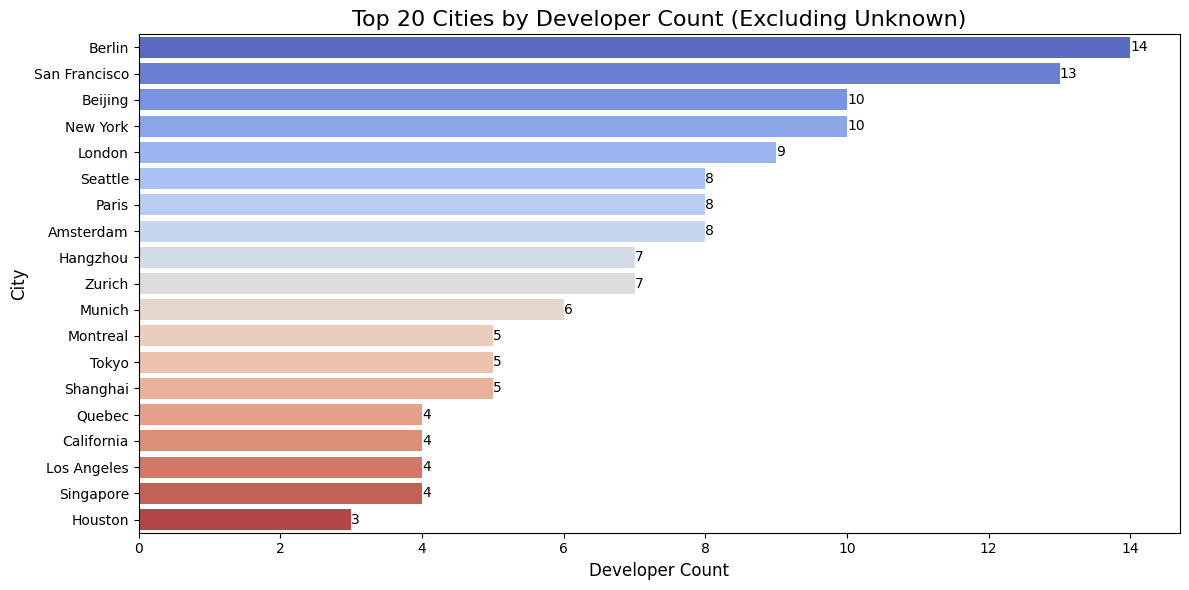

In [7]:
import pandas as pd
import re
import json

# 从 JSON 文件中加载映射
with open("data/location_to_city.json", "r", encoding="utf-8") as f:
    location_to_city = json.load(f)

 

df['city'] = df['location'].map(location_to_city).fillna('Unknown')

# 去重数据，确保每个开发者只统计一次
unique_developers = df[['user_id', 'city']].drop_duplicates()

# 统计每个城市的开发者数量
city_counts = unique_developers['city'].value_counts().reset_index()
city_counts.columns = ['City', 'Developer Count']

# 排序城市排行榜
city_counts = city_counts.sort_values(by='Developer Count', ascending=False)
top_cities = city_counts.head(20)
top_cities = top_cities.reset_index(drop=True)

# 排除 "Unknown" 城市
top_cities_no_unknown = top_cities[top_cities['City'] != 'Unknown']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_cities_no_unknown,
    y='City',
    x='Developer Count',
    hue='City', 
    palette='coolwarm',
    dodge=False 
)
plt.legend([], [], frameon=False)

plt.title("Top 20 Cities by Developer Count (Excluding Unknown)", fontsize=16)
plt.xlabel("Developer Count", fontsize=12)
plt.ylabel("City", fontsize=12)

for index, value in enumerate(top_cities_no_unknown['Developer Count']):
    plt.text(value, index, f"{value}", va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

技术热点城市及原因分析：

Berlin（14 名）：排名第一，显示了德国首都作为技术和开源活动的重要枢纽，具有较高的开发者
密度。
San Francisco（13 名）：旧金山，位列第二，作为硅谷核心城市，是全球技术产业的心脏之一，
吸引了大量开发者。
Beijing（10 名）：中国的技术中心，反映了中国科技社区的快速发展。
New York（10 名）：全球金融和科技结合的重要城市，展现了其技术影响力。
London（9 名）：欧洲技术热点城市之一，展示了英国在国际开源和技术社区中的活跃度。
Seattle（8 名）：微软和亚马逊总部所在地，技术产业的核心城市。
Paris（8 名）：法国的技术和开源中心。
Amsterdam（8 名）：荷兰技术生态系统的枢纽。
Hangzhou（7 名）：阿里巴巴的总部所在地，中国技术产业的重要城市。
Zurich（7 名）：瑞士的研发中心，因其技术人才和国际化社区而著名。
Munich（6 名）：德国的另一个技术城市，展示了德国在技术领域的广泛参与。

对于时区相关分析，由于数据集中并不包括时区的相关信息，故我们要根据国家在数据集中自行补充其时区信息。

我们先打印出所有`country`的取值，再构建起`country`到时区的一一映射，最后绘制这500个开发者的时区分布条形图。

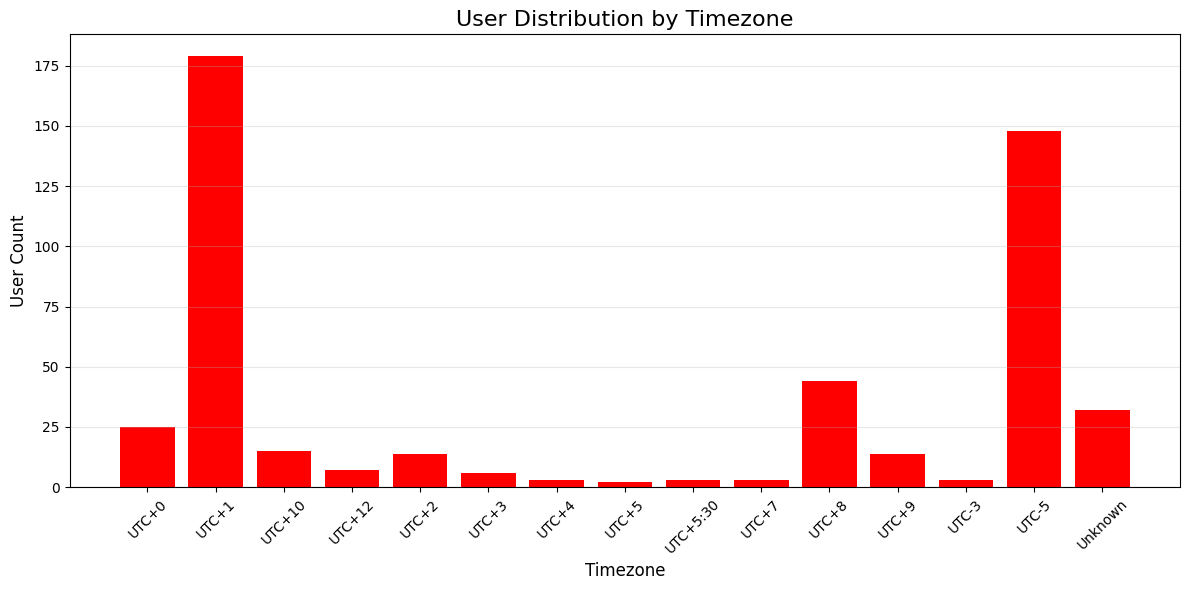

In [8]:
with open("data/country_to_timezone.json", "r", encoding="utf-8") as f:
    country_to_timezone = json.load(f)

df['timezone'] = df['country'].map(country_to_timezone).fillna('Unknown')

# 对用户去重
unique_users = df[['user_id', 'timezone']].drop_duplicates()

timezone_counts = unique_users['timezone'].value_counts().reset_index()
timezone_counts.columns = ['Timezone', 'User Count']
# 按时区递增排序
timezone_counts = timezone_counts.sort_values(by='Timezone')

plt.figure(figsize=(12, 6))
plt.bar(timezone_counts['Timezone'], timezone_counts['User Count'], color='red')
plt.xlabel("Timezone", fontsize=12)
plt.ylabel("User Count", fontsize=12)
plt.title("User Distribution by Timezone", fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

时区分布特点：
UTC+1 即欧洲中部，是用户分布最多的时区，显示出较强的技术社区集中性。
UTC-5 即美国东部，是用户集中的区域
UTC+8 即中国，人也很多

下面是他们工作活动的气泡图，下面这张图纵轴是以UTC+8即北京时间为基准

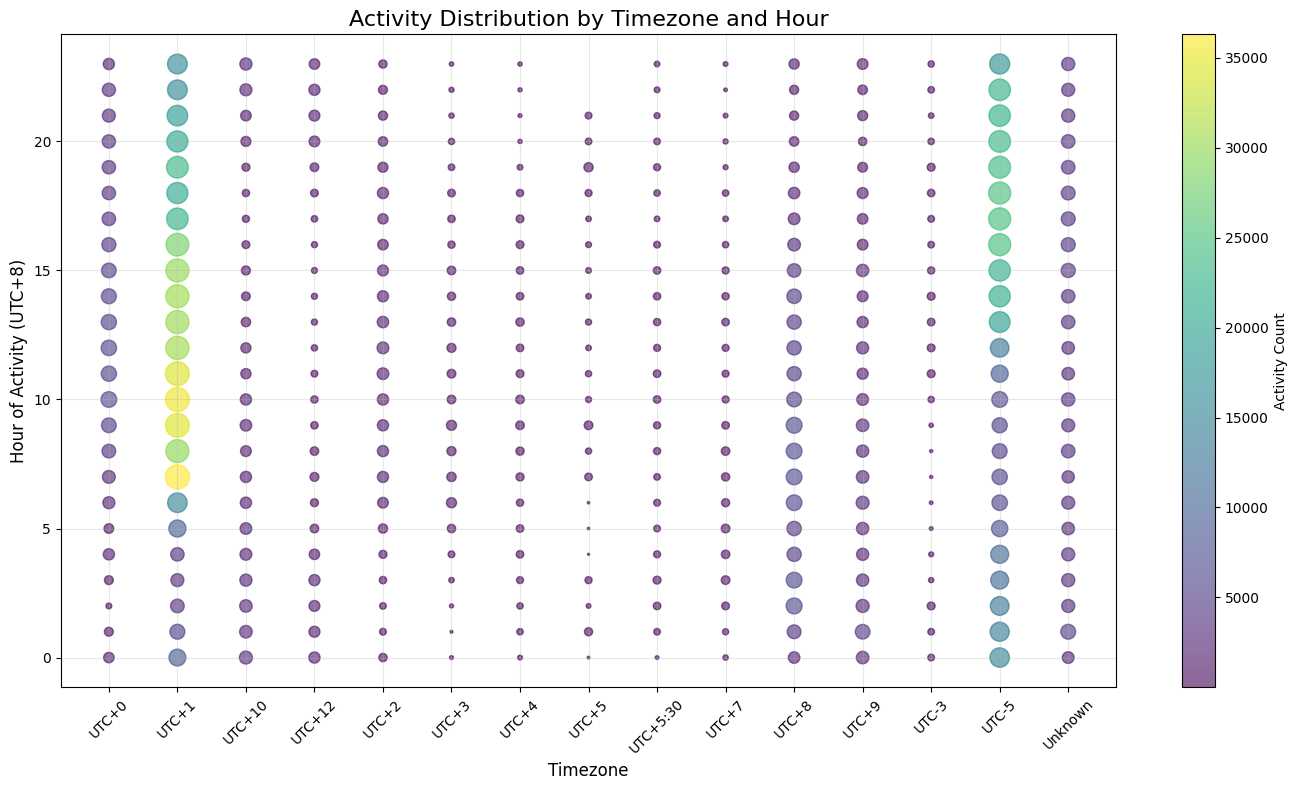

In [9]:
import numpy as np

# 提取活动时间的小时部分
df['event_hour'] = pd.to_datetime(df['event_time']).dt.hour

# 按时区和小时统计活动数量
activity_counts = df.groupby(['timezone', 'event_hour']).size().reset_index(name='Activity Count')

# 绘制气泡图
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    x=activity_counts['timezone'],
    y=activity_counts['event_hour'],
    s=np.sqrt(activity_counts['Activity Count']) * 1.6, 
    alpha=0.6,
    c=activity_counts['Activity Count'],
    cmap='viridis'
)

# 添加颜色条以表示活动数量
plt.colorbar(scatter, label='Activity Count')

# 图表美化
plt.title("Activity Distribution by Timezone and Hour", fontsize=16)
plt.xlabel("Timezone", fontsize=12)
plt.ylabel("Hour of Activity (UTC+8)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

# 展示气泡图
plt.show()

下面这张图的纵轴的时间是各个时区分别对应的时间。

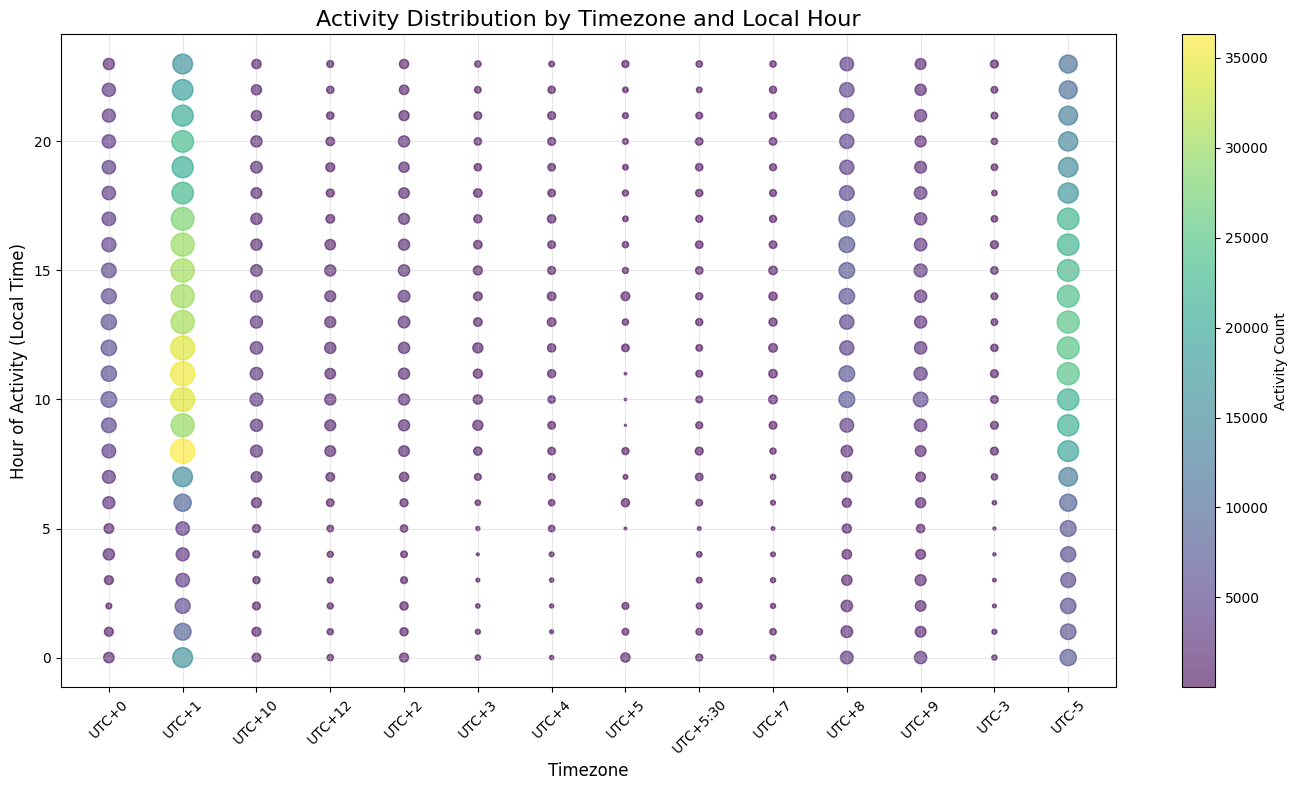

In [10]:
# 提取活动时间的小时部分
df['event_hour'] = pd.to_datetime(df['event_time']).dt.hour

def adjust_to_local_hour(row):
    timezone = row['timezone']
    event_hour = row['event_hour']
    
    if timezone == "Unknown":  # 跳过未知时区
        return np.nan
    
    match = re.match(r'UTC([+-]\d+)', timezone)
    if match:
        offset = int(match.group(1))
        local_hour = (event_hour + offset) % 24 
        return local_hour
    else:
        return np.nan

# 应用调整函数
df['local_event_hour'] = df.apply(adjust_to_local_hour, axis=1)

# 按时区和本地小时统计活动数量
activity_counts = df.groupby(['timezone', 'local_event_hour']).size().reset_index(name='Activity Count')

# 绘制气泡图
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    x=activity_counts['timezone'],
    y=activity_counts['local_event_hour'],
    s=np.sqrt(activity_counts['Activity Count']) * 1.6, 
    alpha=0.6,
    c=activity_counts['Activity Count'],
    cmap='viridis'
)

# 添加颜色条以表示活动数量
plt.colorbar(scatter, label='Activity Count')

# 图表美化
plt.title("Activity Distribution by Timezone and Local Hour", fontsize=16)
plt.xlabel("Timezone", fontsize=12)
plt.ylabel("Hour of Activity (Local Time)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

# 展示气泡图
plt.show()

上面两张图分别是纵轴为 北京时间 和 本地时间 的这500个开发者他们工作活动的气泡图。我们主要分析本地时间的图，更能反映他们的生活工作状态。

可以看到：

9:00-12:00 和 14:00-17:00 是主要的协作高峰时段。这表明大多数开发者的协作活动集中在标准工作时间内，符合典型的工作模式。

不同时区的工作特点：


UTC+1（欧洲时区）：活跃度最高，尤其集中在工作时间的高峰期（9:00-17:00），表现出强烈的工作日协作模式。
UTC-5（北美时区）：活动较为分散，但主要集中在上午和下午，与典型的工作时间一致。
UTC+8（中国）：活动集中在上午到下午，表现出类似的工作习惯，晚间活动21:00-23:00略有增加，可能与加班有关。

### 2.协作行为分析
提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。

In [14]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# 统计每个用户的提交次数
user_activity = df['name'].value_counts().reset_index()
user_activity.columns = ['name', 'Submission Count']

# 取前30名用户和末尾30名用户
top_users = user_activity.head(30)
bottom_users = user_activity.tail(30)

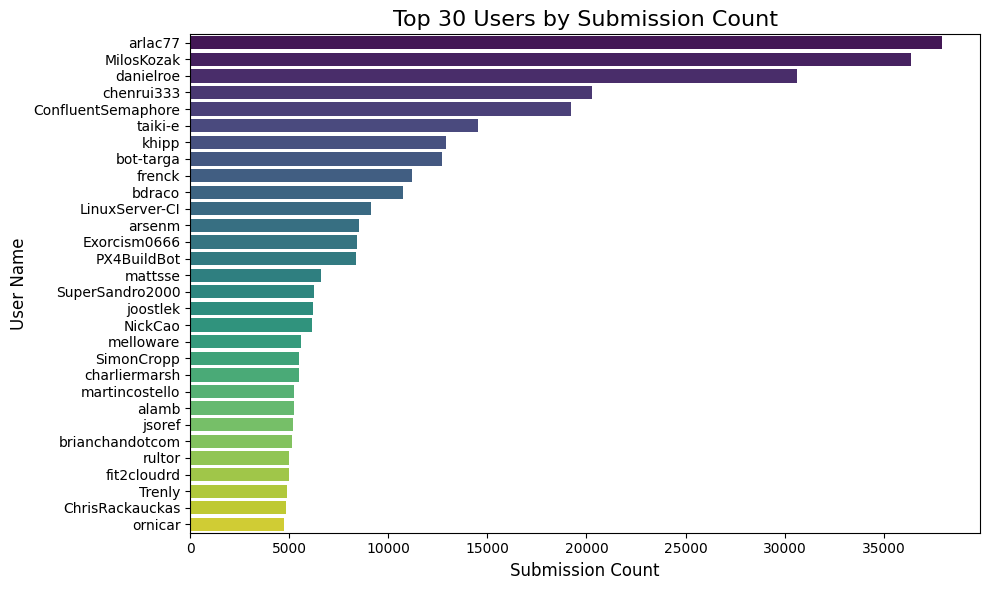

In [15]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=top_users,
    y='name', 
    x='Submission Count', 
    hue='name',  # 将 name 映射到颜色调色板
    dodge=False,  # 禁用分组
    palette='viridis', 
    legend=False  # 禁用图例
)
plt.title("Top 30 Users by Submission Count", fontsize=16)
plt.xlabel("Submission Count", fontsize=12)
plt.ylabel("User Name", fontsize=12)
plt.tight_layout()
plt.show()

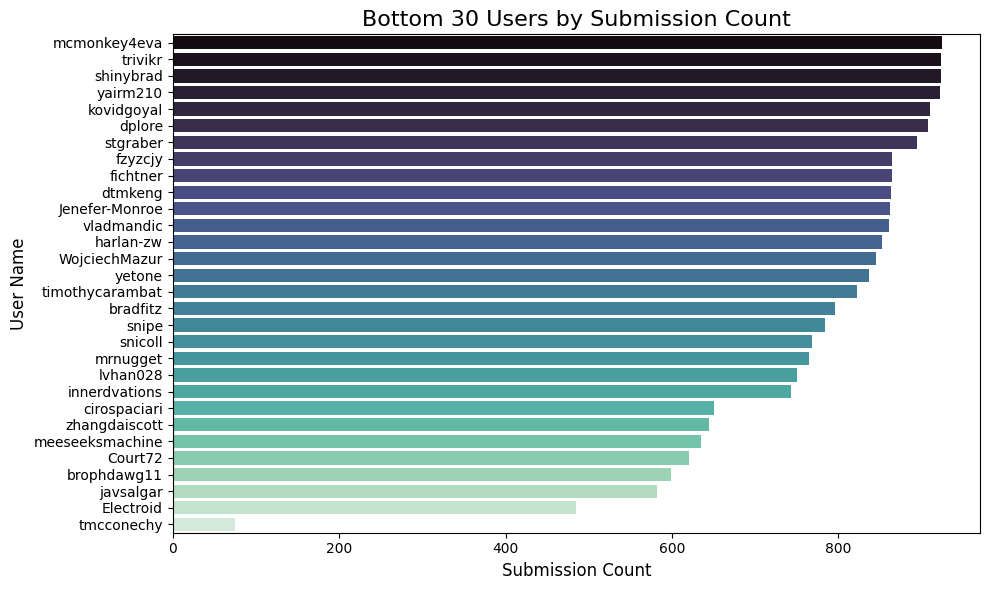

In [16]:
# 绘制末尾20名用户
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bottom_users,
    y='name', 
    x='Submission Count', 
    hue='name',  # 将 name 映射到颜色调色板
    dodge=False, 
    palette='mako', 
    legend=False
)

plt.title("Bottom 30 Users by Submission Count", fontsize=16)
plt.xlabel("Submission Count", fontsize=12)
plt.ylabel("User Name", fontsize=12)
plt.tight_layout()
plt.show()


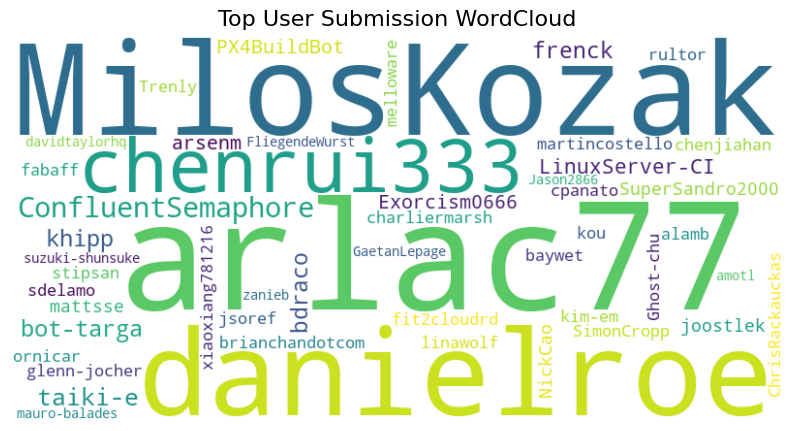

In [17]:
from wordcloud import WordCloud

# 构造词云数据：用户ID -> 提交次数
wordcloud_data = {str(row['name']): row['Submission Count'] for _, row in user_activity.head(50).iterrows()}

# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# 绘制词云
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top User Submission WordCloud", fontsize=16)
plt.show()


### 3.其他维度有趣的观察
(1)用户影响力榜单：

In [19]:
# 统计每个用户的平均影响力、国家和地区
user_stats = df.groupby('name', as_index=False).agg({
    'total_influence': 'mean',  # 平均影响力
    'location': 'first'         # 用户的地区
})

# 排序并提取影响力前20名用户
top_influence_users = user_stats.sort_values(by='total_influence', ascending=False).head(20)
# 重置索引
top_influence_users_reset = top_influence_users.reset_index(drop=True)

# 打印结果
print("Top 20 Users by Total Influence:")
print(top_influence_users_reset)

Top 20 Users by Total Influence:
               name  total_influence                       location
0            bdraco      1776.967163                    Houston, TX
1            Koenkk      1674.805908       The Netherlands, Helmond
2            fabaff      1590.152954                    Switzerland
3     charliermarsh      1580.198242                   Brooklyn, NY
4            frenck      1520.352173      Enschede, The Netherlands
5      glenn-jocher      1392.865723             Spain ⇄ California
6   SuperSandro2000      1220.031738                        Germany
7          joostlek      1219.017944       Utrecht, The Netherlands
8     mauro-balades      1201.465759  5 centimeters from the screen
9           NickCao      1120.395699                         Boston
10         vaxerski      1029.454956                 Acheron, Hades
11        melloware      1025.852783               Philadelphia, PA
12            Mic92       996.933105                            ::1
13    Jarred-Su

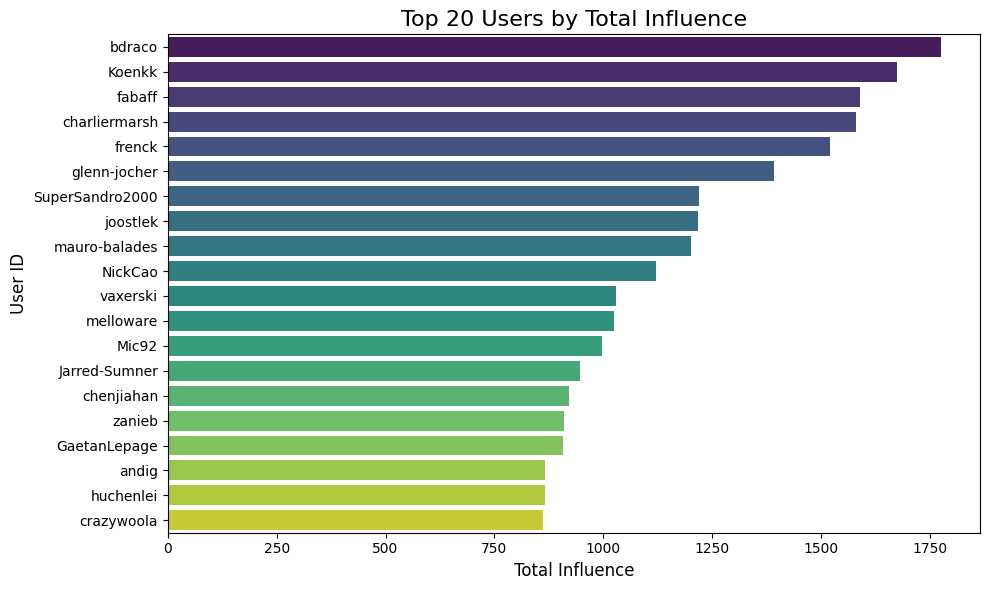

In [20]:
# 绘制影响力 TOP 20 排行榜
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_influence_users,
    y='name', 
    x='total_influence', 
    palette='viridis',
    hue='name',  # 设置 hue 为 y 轴变量
    dodge=False,  # 禁止分组
    legend=False  # 禁用图例
)
plt.title("Top 20 Users by Total Influence", fontsize=16)
plt.xlabel("Total Influence", fontsize=12)
plt.ylabel("User ID", fontsize=12)
plt.tight_layout()
plt.show()

(2) 工作日与周末的日均活动数目与活动时间对比：

为了了解工作日与周末的日均活动数目与活动时间，即开发者们工作日和周末开发项目
的情况。
因为数据集里所有活动时间是基于UTC+8的，因此我们需要将活动时间转换为本地时间。

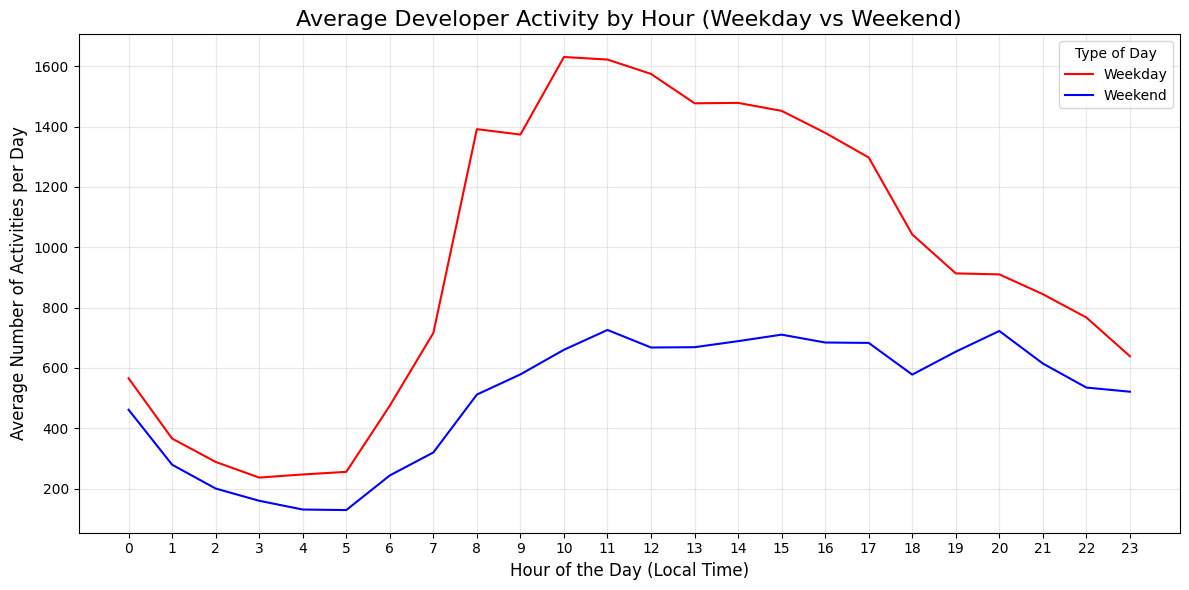

In [22]:
df['event_hour'] = pd.to_datetime(df['event_time']).dt.hour

def adjust_to_local_hour(row):
    timezone = row['timezone']
    event_hour = row['event_hour']
    if timezone == "Unknown": 
        return np.nan
    
    match = re.match(r'UTC([+-]\d+)', timezone)
    if match:
        offset = int(match.group(1))
        local_hour = (event_hour + offset) % 24 
        return local_hour
    else:
        return np.nan

df['local_event_hour'] = df.apply(adjust_to_local_hour, axis=1)

df['event_date'] = pd.to_datetime(df['event_time']).dt.date
df['is_weekend'] = pd.to_datetime(df['event_date']).dt.dayofweek >= 5 

num_weekdays = len(df[df['is_weekend'] == False]['event_date'].unique())  # 工作日天数
num_weekends = len(df[df['is_weekend'] == True]['event_date'].unique())   # 周末天数

hourly_activity_weekday = df[df['is_weekend'] == False]['local_event_hour'].value_counts().sort_index() / num_weekdays
hourly_activity_weekend = df[df['is_weekend'] == True]['local_event_hour'].value_counts().sort_index() / num_weekends

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_activity_weekday.index, y=hourly_activity_weekday.values, label='Weekday', color='red')
sns.lineplot(x=hourly_activity_weekend.index, y=hourly_activity_weekend.values, label='Weekend', color='blue')
plt.title("Average Developer Activity by Hour (Weekday vs Weekend)", fontsize=16)
plt.xlabel("Hour of the Day (Local Time)", fontsize=12)
plt.ylabel("Average Number of Activities per Day", fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title="Type of Day")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

可以看到：

工作日的活动总量显著高于周末，周末的活动较分散，高峰时间段较宽，说明开发者的主要贡献仍集中在工作日，开发者们在周末处理开源项目相对比较灵活。

无论是周末还是工作日，开发者的活动高峰都在8:00-18:00。

工作日到了18 点之后活动量显著减少，开发者在晚上更倾向于休息或减少技术活动；而加班现象在周末则更普遍。

(3) event_type字段中事件种类的分布饼状图：

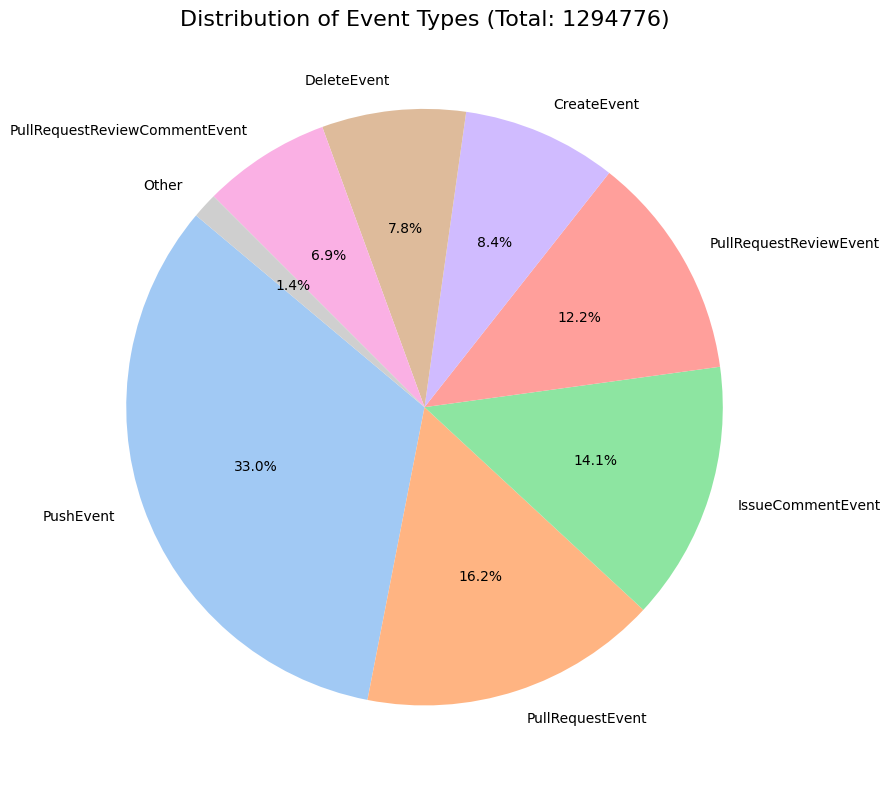

In [23]:
event_type_distribution = df['event_type'].value_counts()

total_events = event_type_distribution.sum()
event_type_percent = (event_type_distribution / total_events) * 100

event_type_distribution_adjusted = event_type_distribution.copy()
event_type_distribution_adjusted[event_type_percent < 5] = 0  # 将低于 5% 的类型归为 "Other"
event_type_distribution_adjusted["Other"] = event_type_distribution[event_type_percent < 2].sum()

event_type_distribution_adjusted = event_type_distribution_adjusted[event_type_distribution_adjusted > 0]

# 绘制调整后的饼状图
plt.figure(figsize=(10, 8))
plt.pie(
    event_type_distribution_adjusted.values, 
    labels=event_type_distribution_adjusted.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel', len(event_type_distribution_adjusted))
)
plt.title(f"Distribution of Event Types (Total: {total_events})", fontsize=16)
plt.tight_layout()
plt.show()

PushEvent 是最常见的事件类型，占比 33.0%，几乎是其他单一事件类型的两倍，表示代码被推送到仓库，这表明代码提交是协作活动的核心。

PullRequestEvent （16.2%）占比第二，仅次于 PushEvent ，表明开发者在开源协作中积极使用
PR 模式，进行代码合并和功能开发。PullRequestReviewEvent （12.2%）的较高占比说明代码审查是协作的重要组成部分。开发者不仅提交代码，还积极参与代码质量的提升。

IssueCommentEvent （14.1%）占比第三，接近 PullRequestEvent ，说明评论和讨论是协作的重要环节。